# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

From the paper USING DATA MINING FOR BANK DIRECT MARKETING: AN APPLICATION OF THE CRISP-DM METHODOLOGY in the Materials and Methods section page 2:
 
"The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored (e.g. see Table 2) and if there was a success (the target variable). For the whole database considered, there were 6499 successes (8% success rate)."

Each row represents and instance of a client being contacted as part of a campaign.  A client can be contacted multiple time.  The data in each row has the result of the last contact.  All intermidiate contact data is lost once the row is updated with the last contact data.

The original data had 79,354 rows with 59 client attributes some of which had missing values.  The data for the exercise has already been cleaned and irrelevant attributes were discarded.  Categorical features missing values were replaced with the "unknown" value.

The resulting dataset has 41,188 rows with 20 attributes and 1 target.  The target is binary being no or yes.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# Full sample dataset, ordered by date (from May 2008 to November 2010)
dfBankDM = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
dfBankDM.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# 10% of samples (4119), randomly selected from bank-additional-full.csv
# This dataset is provided to test more computationally demanding machine learning algorithms (e.g., SVM)
dfBankSmallDM = pd.read_csv('data/bank-additional.csv', sep = ';')

In [6]:
dfBankSmallDM.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
# Inspect row count, column type, and non-null count 
dfBankDM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
# Check for nulls
dfNulls = dfBankDM.isna().sum().to_frame(name='NullCount')

# Calculate % of nulls vs total
dfNulls['Percentage'] = dfNulls['NullCount'] / len(dfBankDM) * 100

# List columns by descending % of null values
dfNulls.sort_values(['Percentage'], ascending=False)

,NullCount,Percentage
age,0,0.0
campaign,0,0.0
nr.employed,0,0.0
euribor3m,0,0.0
cons.conf.idx,0,0.0
cons.price.idx,0,0.0
emp.var.rate,0,0.0
poutcome,0,0.0
previous,0,0.0
pdays,0,0.0


#### Data Summary

- 41,118 rows
- 20 feature columns
- 1 target column
- No missing values
- No transformation to different data type


In [9]:
# Accepted Pecentage, to find if the data is balanced
dfBankDM['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [10]:
print('Accepted Campaign ', round(dfBankDM['y'].value_counts()['yes'] / len(dfBankDM) * 100, 2), '%')

Accepted Campaign  11.27 %


#### The accepted campaing percentage of 11.27% of the sample indicates the data is unbalanced.

#### Plot various categorical data to determine if the data is unbalaced across features

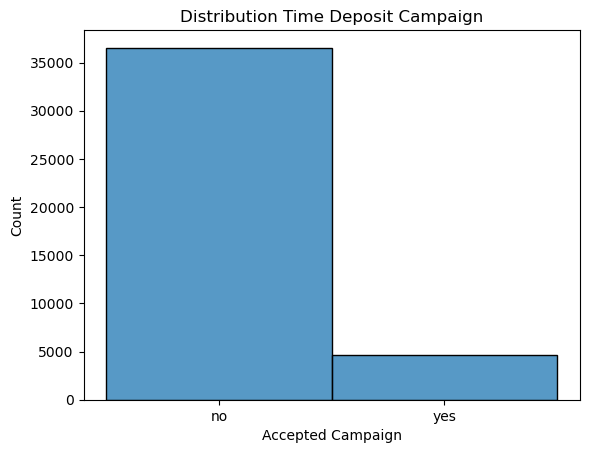

In [11]:
sns.histplot(dfBankDM, x='y')
plt.title('Distribution Time Deposit Campaign')
plt.xlabel('Accepted Campaign')
plt.show()

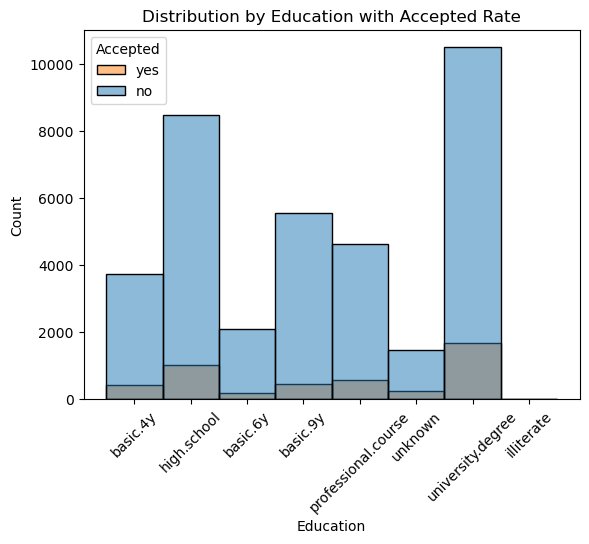

In [12]:
sns.histplot(dfBankDM, x='education', hue='y')
plt.title('Distribution by Education with Accepted Rate')
plt.xlabel('Education')
plt.xticks(rotation=45)
plt.legend(title='Accepted', labels=['yes', 'no'])
plt.show()

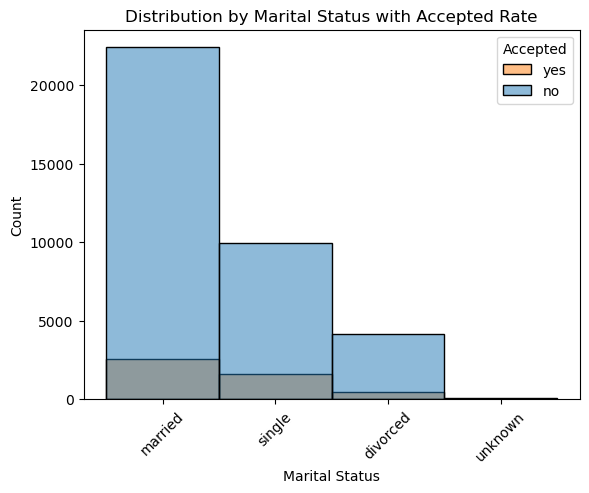

In [13]:
sns.histplot(dfBankDM, x='marital', hue='y')
plt.title('Distribution by Marital Status with Accepted Rate')
plt.xlabel('Marital Status')
plt.xticks(rotation=45)
plt.legend(title='Accepted', labels=['yes', 'no'])
plt.show()

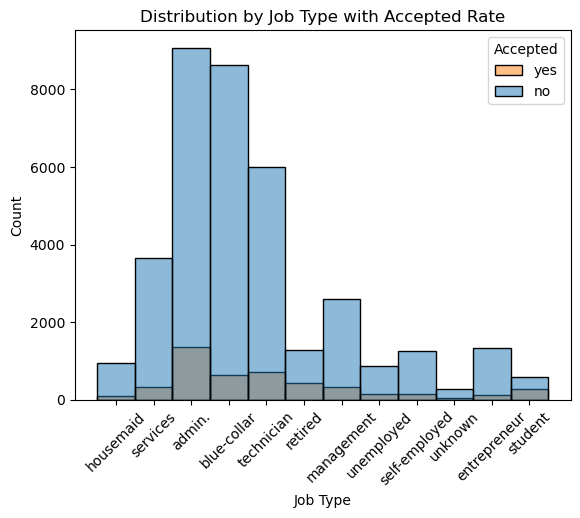

In [14]:
sns.histplot(dfBankDM, x='job', hue='y')
plt.title('Distribution by Job Type with Accepted Rate')
plt.xlabel('Job Type')
plt.xticks(rotation=45)
plt.legend(title='Accepted', labels=['yes', 'no'])
plt.show()

Histograms show that client distribution by education is not normal with university degree holders having a better acceptace rate than other education levels.

In general, the data is unbalanced for the various categorical features

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective
The business objective is to produce a model to predict if a customer will subscribe a bank time deposit.  The model should ideally yield interpretable results.

#### Exercise Objective
The exercise objective is to compare the performance of the results of k-nearest neighbors, logistic regression, decision trees, and support vector machines.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

<table>
  <thead>
    <tr>
      <th style="text-align:center">Column</th>
      <th style="text-align:center">Encoder</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align:left">job</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">marital</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">education</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">default</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">housing</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">loan</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">contact</td>
      <td style="text-align:left">Ordinal Encoder<br>no rank</td>
    </tr>
    <tr>
      <td style="text-align:left">month</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">day_of_week</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
    <tr>
      <td style="text-align:left">poutcome</td>
      <td style="text-align:left">Ordinal Encoder<br>with rank</td>
    </tr>
  </tbody>
</table>

In [15]:
# Features for ordinal encoding with random rank
ore_features = ['contact']

# Features for ordinal encoding with specif rank
orr_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome']

In [16]:
# Rank for Ordinal encoding features
orr_job = ['unknown', 'unemployed', 'housemaid', 'student', 'self-employed', 'entrepreneur', 'blue-collar', 'technician', 'services', 'admin.', 'management', 'retired']
orr_marital = ['unknown', 'single', 'divorced', 'married']
orr_education = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
orr_default = ['unknown', 'no', 'yes']
orr_housing = ['unknown', 'no', 'yes']
orr_loan = ['unknown', 'no', 'yes']
orr_month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
orr_day = ['mon', 'tue', 'wed', 'thu', 'fri']
orr_poutcome = ['nonexistent', 'failure', 'success']


In [17]:
# OrdinalEncoder without rank
oee = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# OrdinalEncoder with rank
oer = OrdinalEncoder(categories=
    [orr_job, 
     orr_marital, 
     orr_education, 
     orr_default, 
     orr_housing, 
     orr_loan, 
     orr_month, 
     orr_day, 
     orr_poutcome], dtype=int)


In [18]:
# Create column transformation
col_transformer = make_column_transformer(
    (oee, ore_features), 
    (oer, orr_features ),
    remainder='passthrough')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [19]:
# Create X and y datasets for model
X = dfBankDM.drop(columns=['y', 'duration'], axis = 1)
y = dfBankDM['y']

In [20]:
# Spit the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 42)

In [21]:
### Test transformation
X_transform = col_transformer.fit_transform(X_train)

In [22]:
feature_names = col_transformer.get_feature_names_out()
feature_names

array(['ordinalencoder-1__contact', 'ordinalencoder-2__job',
       'ordinalencoder-2__marital', 'ordinalencoder-2__education',
       'ordinalencoder-2__default', 'ordinalencoder-2__housing',
       'ordinalencoder-2__loan', 'ordinalencoder-2__month',
       'ordinalencoder-2__day_of_week', 'ordinalencoder-2__poutcome',
       'remainder__age', 'remainder__campaign', 'remainder__pdays',
       'remainder__previous', 'remainder__emp.var.rate',
       'remainder__cons.price.idx', 'remainder__cons.conf.idx',
       'remainder__euribor3m', 'remainder__nr.employed'], dtype=object)

In [23]:
# Create X and y datasets for model SVC
Xsmall = dfBankSmallDM.drop(columns=['y', 'duration'], axis = 1)
ysmall = dfBankSmallDM['y']

In [24]:
# Spit the data into train and test
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, ysmall, test_size=0.30, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [25]:
# Pipeline to transform
dummy_pipe = Pipeline([
    ('transformer', col_transformer),
    ('dummy', DummyClassifier(random_state=42))
])

dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['contact']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'unemployed',
                                                                              'housemaid',
                                                                              'student',
                                                                              'self-employed',
                                                                              'entrepreneur',
                                                                              'blue-collar',
                                                                              'technician',
                                                                              'services',...
                                                                              'yes'],
                                                                             ['unknown',
                                                                              'no',
                                                                              'yes'],
                                                                             ['unknown',
                                                                              'no',
                                                                              'yes'],
                                                                             ['jan',
                                                                              'feb',
                                                                              'mar',
                                                                              'apr',
                                                                              'may',
                                                                              'jun',
                                                                              'jul',
                                                                              'aug',
                                                                              'sep',
                                                                              'oct',
                                                                              'nov',
                                                                              'dec'],
                                                                             ['mon',
                                                                              'tue',
                                                                              'wed',
                                                                              'thu',
                                                                              'fri'],
                                                                             ['nonexistent',
                                                                              'failure',
                                                                              'success']],
                                                                 dtype=<class 'int'>),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'month',
                                                   'day_o

In [26]:
print('Accuracy Train' , dummy_pipe.score(X_train, y_train))
print('Accuracy Test ', dummy_pipe.score(X_test, y_test))

Accuracy Train 0.8872394297804447
Accuracy Test  0.8875940762320952


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [27]:
# Calculate elapsed time
def elapsed_time(start, finish):
    return (finish - start)

In [28]:
# Pipeline to transform
lgr_pipe = Pipeline([
    ('transformer', col_transformer),
    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))
])

# Fit and keep track of time
start = time.time()
lgr_pipe.fit(X_train, y_train)
stop = time.time()

### Problem 9: Score the Model

What is the accuracy of your model?

In [29]:
print('Accuracy Train' , lgr_pipe.score(X_train, y_train))
print('Accuracy Test ', lgr_pipe.score(X_test, y_test))

Accuracy Train 0.900142208039957
Accuracy Test  0.8995710933074371


In [30]:
lgr_predict = lgr_pipe.predict(X_test)

In [31]:
precision_test = precision_score(y_test, lgr_predict, pos_label='yes')
accuracy_test = accuracy_score(y_test, lgr_predict)

print('Precision ', precision_test)
print('Accuracy', accuracy_test)

Precision  0.6804878048780488
Accuracy 0.8995710933074371


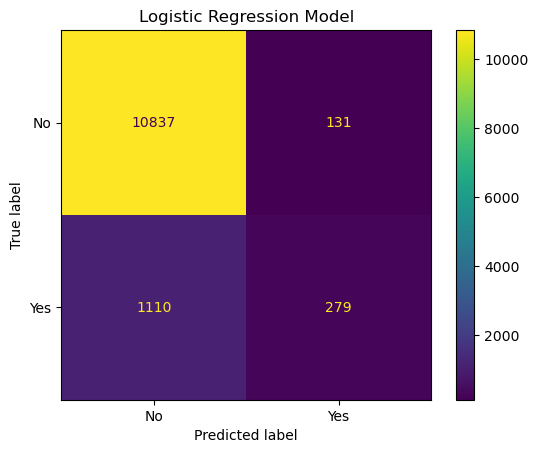

In [32]:
campaign_confusion_mat  = confusion_matrix(y_test, lgr_predict, labels=lgr_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=campaign_confusion_mat ,display_labels = ['No', 'Yes'])
disp.plot()
plt.title('Logistic Regression Model')
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### Tracking results dataframe

In [33]:
# Create tracking dataframe
dfTrack = pd.DataFrame({ 
    'model' : pd.Series(dtype='str'),
    'Train Time' : pd.Series(dtype='float'), 
    'Train Accuracy' : pd.Series(dtype='float'),
    'Test Accuracy' : pd.Series(dtype='float')
})

dfTrack.set_index('model')

,Train Time,Train Accuracy,Test Accuracy
model,,,


In [34]:
# Save results Logistic Regression 

new_row = pd.DataFrame([
    { 
    'model' : 'LogisticRegression',
    'Train Time' : elapsed_time(start, stop), 
    'Train Accuracy' : lgr_pipe.score(X_train, y_train),
    'Test Accuracy' : lgr_pipe.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

#### KNN

In [35]:
# Pipeline to transform
knn_pipe = Pipeline([
    ('transformer', col_transformer),
    ('knn', KNeighborsClassifier())
])

# Fit and keep track of time
start = time.time()
knn_pipe.fit(X_train, y_train)
stop = time.time()

print('Accuracy Train' , knn_pipe.score(X_train, y_train))
print('Accuracy Test ', knn_pipe.score(X_test, y_test))

Accuracy Train 0.9143630120356561
Accuracy Test  0.8906692562919802


In [36]:
# Save results KNearest Neighbor

new_row = pd.DataFrame([
    { 
    'model' : 'KNN',
    'Train Time' : elapsed_time(start, stop), 
    'Train Accuracy' : knn_pipe.score(X_train, y_train),
    'Test Accuracy' : knn_pipe.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

In [37]:
knn_predict = knn_pipe.predict(X_test)

precision_test = precision_score(y_test, knn_predict, pos_label='yes')
accuracy_test = accuracy_score(y_test, knn_predict)

print('Precision ', precision_test)
print('Accuracy', accuracy_test)

Precision  0.5253333333333333
Accuracy 0.8906692562919802


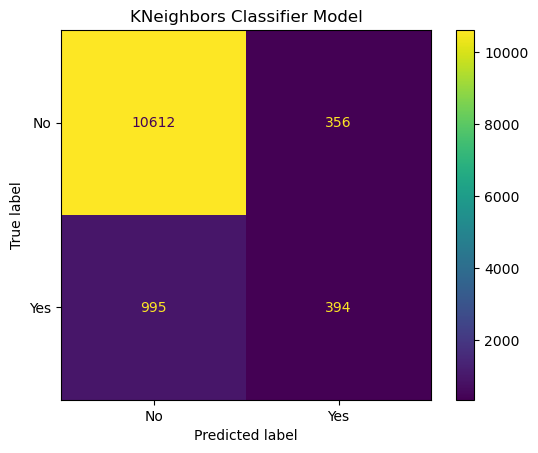

In [38]:
campaign_confusion_mat  = confusion_matrix(y_test, knn_predict, labels=knn_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=campaign_confusion_mat ,display_labels = ['No', 'Yes'])
disp.plot()
plt.title('KNeighbors Classifier Model')
plt.show()

#### Decision Tree

In [39]:
# Pipeline to transform
dt_pipe = Pipeline([
    ('transformer', col_transformer),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Fit and keep track of time
start = time.time()
dt_pipe.fit(X_train, y_train)
stop = time.time()

print('Accuracy Train' , dt_pipe.score(X_train, y_train))
print('Accuracy Test ', dt_pipe.score(X_test, y_test))

Accuracy Train 0.9955950192501127
Accuracy Test  0.8336974993930566


In [40]:
# Save results Decision Tree

new_row = pd.DataFrame([
    { 
    'model' : 'Decision Tree',
    'Train Time' : elapsed_time(start, stop), 
    'Train Accuracy' : dt_pipe.score(X_train, y_train),
    'Test Accuracy' : dt_pipe.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

In [41]:
dt_predict = dt_pipe.predict(X_test)

precision_test = precision_score(y_test, dt_predict, pos_label='yes')
accuracy_test = accuracy_score(y_test, dt_predict)

print('Precision ', precision_test)
print('Accuracy', accuracy_test)


Precision  0.29135338345864664
Accuracy 0.8336974993930566


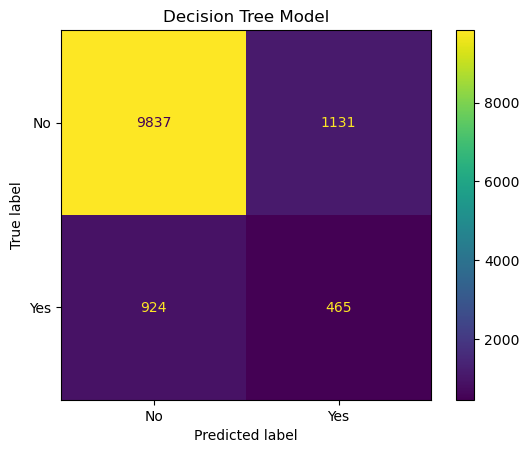

In [42]:
campaign_confusion_mat  = confusion_matrix(y_test, dt_predict, labels=dt_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=campaign_confusion_mat ,display_labels = ['No', 'Yes'])
disp.plot()
plt.title('Decision Tree Model')
plt.show()

#### SVM

In [43]:
# Pipeline to transform
svm_pipe = Pipeline([
    ('transformer', col_transformer),
    ('svm', SVC(random_state=42))
])

# Fit and keep track of time
start = time.time()
svm_pipe.fit(X_train, y_train)
stop = time.time()

print('Accuracy Train' , svm_pipe.score(X_train, y_train))
print('Accuracy Test ', svm_pipe.score(X_test, y_test))

Accuracy Train 0.897818320557733
Accuracy Test  0.8968196164117505


In [44]:
# Save results SVC

new_row = pd.DataFrame([
    { 
    'model' : 'SVC',
    'Train Time' : elapsed_time(start, stop), 
    'Train Accuracy' : svm_pipe.score(X_train, y_train),
    'Test Accuracy' : svm_pipe.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

In [45]:
svm_predict = svm_pipe.predict(X_test)

precision_test = precision_score(y_test, svm_predict, pos_label='yes')
accuracy_test = accuracy_score(y_test, svm_predict)

print('Precision ', precision_test)
print('Accuracy', accuracy_test)

Precision  0.6197478991596639
Accuracy 0.8968196164117505


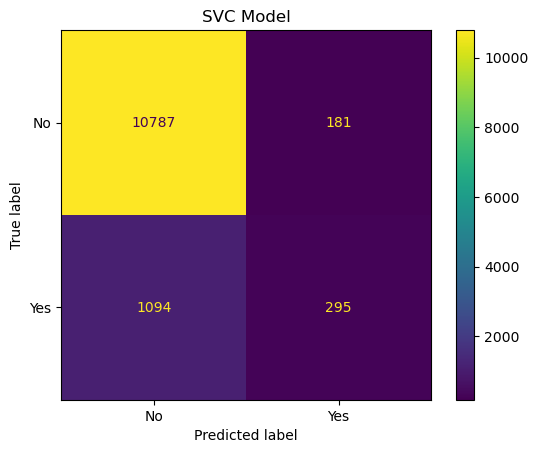

In [46]:
campaign_confusion_mat  = confusion_matrix(y_test, svm_predict, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=campaign_confusion_mat ,display_labels = ['No', 'Yes'])
disp.plot()
plt.title('SVC Model')
plt.show()

#### Results Base Models

In [47]:
dfTrack

,model,Train Time,Train Accuracy,Test Accuracy
0,LogisticRegression,1.929807,0.900142,0.899571
1,KNN,0.109848,0.914363,0.890669
2,Decision Tree,0.235368,0.995595,0.833697
3,SVC,9.677039,0.897818,0.896820


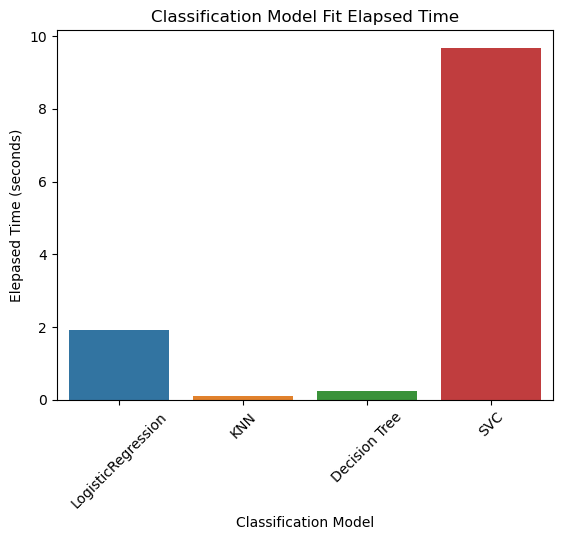

In [48]:
# Plot Elapsed Time
sns.barplot(dfTrack, 
            x='model',
            y='Train Time')
plt.ylabel('Elepased Time (seconds)')
plt.xlabel('Classification Model')
plt.xticks(rotation = 45)
plt.title('Classification Model Fit Elapsed Time')
plt.show()

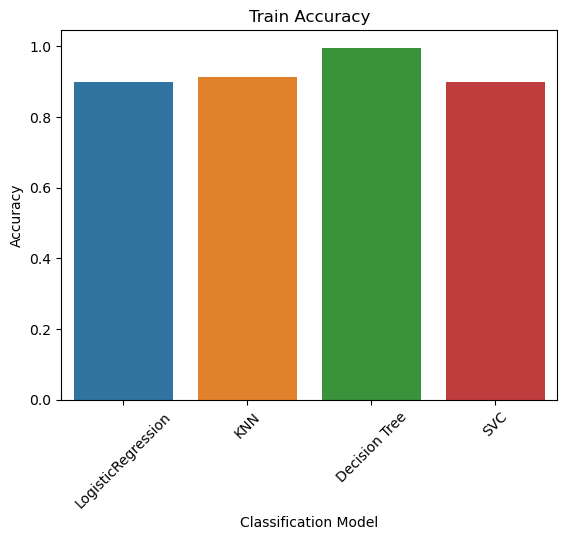

In [49]:
# Plot Train and Test Accuracy
sns.barplot(dfTrack, 
            x='model',
            y='Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Classification Model')
plt.xticks(rotation = 45)
plt.title('Train Accuracy')
plt.show()

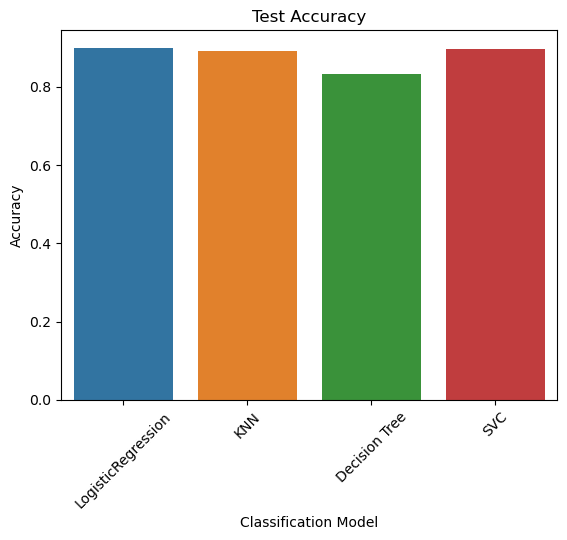

In [50]:
# Plot Train and Test Accuracy
sns.barplot(dfTrack, 
            x='model',
            y='Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Classification Model')
plt.xticks(rotation = 45)
plt.title('Test Accuracy')
plt.show()

#### Best Model so far
There is no clear winner so far.  Logistic Regression, KNN and SVC have very similar accuracy scores for the test data with Decision Tree lagging behind but not much.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [51]:
# Formula obtained from URL
# https://datascience.stackexchange.com/questions/29495/how-to-estimate-gridsearchcv-computing-time

def calculate_time(cv_results, n_splits):
    
    # cv_results
    # A dict with keys as column headers and values as columns from gridsearch tool
    
    # n_splits
    # Number of data splits done in gridsearch tool
    
    mean_fit_time = cv_results['mean_fit_time']
    mean_score_time= cv_results['mean_score_time']
      
    #Iterations per split
    n_iter = pd.DataFrame(cv_results).shape[0] 
    
    return np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter

### Heatmap
Plot a Correlation Matrix to determine if some features can be drop.  Candidates features to drop are those that have a very low correlation to y.



In [52]:
dfHeatMap = dfBankDM.copy(deep=True)
dfHeatMap['y'] = dfHeatMap['y'].map({ 'yes' : 1, 'no' : 0})

col_transformer.set_output(transform='pandas')
dfHeatMap = col_transformer.fit_transform(dfHeatMap)
col_transformer.set_output(transform='default')

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder-1',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['contact']),
                                ('ordinalencoder-2',
                                 OrdinalEncoder(categories=[['unknown',
                                                             'unemployed',
                                                             'housemaid',
                                                             'student',
                                                             'self-employed',
                                                             'entrepreneur',
                                                             'blue-collar',
                                                             'technician',
                                                             'services',
                                                             'admin.',
                                                             'management',
                                                             'retired'...
                                                             'professional.course',
                                                             'university.degree'],
                                                            ['unknown', 'no',
                                                             'yes'],
                                                            ['unknown', 'no',
                                                             'yes'],
                                                            ['unknown', 'no',
                                                             'yes'],
                                                            ['jan', 'feb',
                                                             'mar', 'apr',
                                                             'may', 'jun',
                                                             'jul', 'aug',
                                                             'sep', 'oct',
                                                             'nov', 'dec'],
                                                            ['mon', 'tue',
                                                             'wed', 'thu',
                                                             'fri'],
                                                            ['nonexistent',
                                                             'failure',
                                                             'success']],
                                                dtype=<class 'int'>),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'month', 'day_of_week',
                                  'poutcome'])])

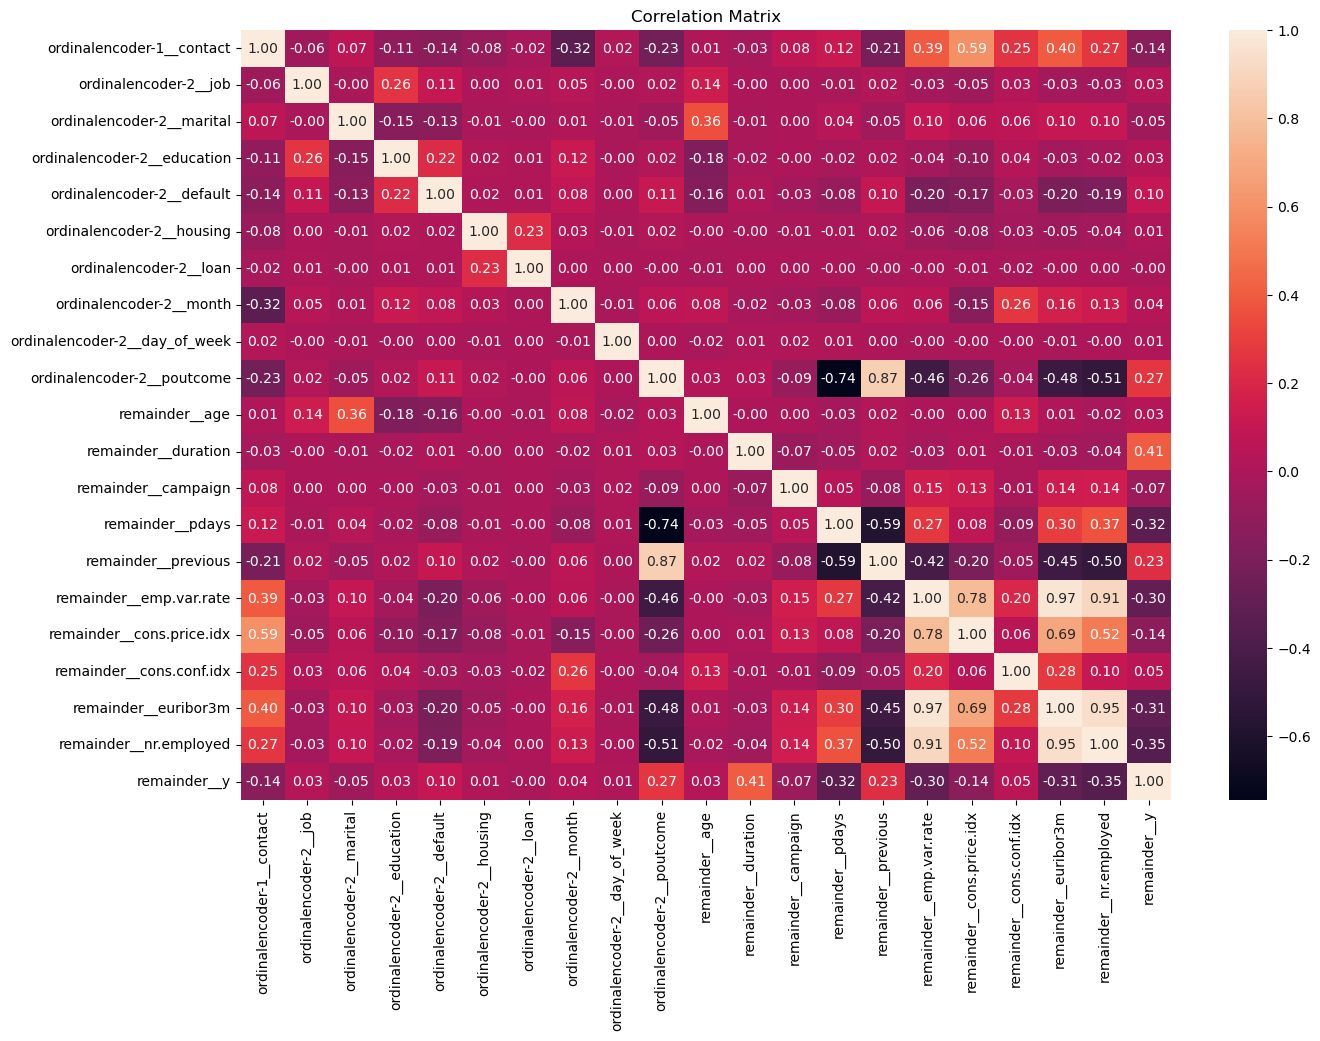

In [53]:
# Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(dfHeatMap.corr(), annot=True, fmt=".2f", )
plt.title('Correlation Matrix')
plt.show()

Correlation Matrix heatmap shows features having a very low correlation to y.  Can't drop any features based on the correlation values.

### Tuning Hyperparameters

#### Logistic Regression

In [54]:
lgr_pipe.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder-1',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['contact']),
                                   ('ordinalencoder-2',
                                    OrdinalEncoder(categories=[['unknown',
                                                                'unemployed',
                                                                'housemaid',
                                                                'student',
                                                                'self-employed',
                                                                'entrepreneur',
                                                                'blue-collar',
                                              

In [55]:
# GridsearchCV

# Define values for hyperparameters to evaluate
# Try solvers that support l2 regularization
params = {'lgr__solver' : ['lbfgs', 'liblinear', 'newton-cg']}

lgr_grid = GridSearchCV(
    estimator=lgr_pipe,
    param_grid=params,
    scoring='accuracy')

lgr_grid.fit(X_train, y_train)

lgr_best = lgr_grid.best_estimator_

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\anaconda3\lib\site-pa

In [56]:
lgr_grid.best_params_

{'lgr__solver': 'newton-cg'}

In [57]:
print('Accuracy Train' , lgr_best.score(X_train, y_train))
print('Accuracy Test ', lgr_best.score(X_test, y_test))

Accuracy Train 0.9006277964690784
Accuracy Test  0.8982762806506434


In [58]:
# Save results Logistic Regression 

new_row = pd.DataFrame([
    { 
    'model' : 'LogisticRegression Optimize',
    'Train Time' : calculate_time(lgr_grid.cv_results_, lgr_grid.n_splits_), 
    'Train Accuracy' : lgr_best.score(X_train, y_train),
    'Test Accuracy' : lgr_best.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

In [59]:
dfTrack 

,model,Train Time,Train Accuracy,Test Accuracy
0,LogisticRegression,1.929807,0.900142,0.899571
1,KNN,0.109848,0.914363,0.890669
2,Decision Tree,0.235368,0.995595,0.833697
3,SVC,9.677039,0.897818,0.896820
4,LogisticRegression Optimize,17.806170,0.900628,0.898276


#### KNN

In [60]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder-1',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['contact']),
                                   ('ordinalencoder-2',
                                    OrdinalEncoder(categories=[['unknown',
                                                                'unemployed',
                                                                'housemaid',
                                                                'student',
                                                                'self-employed',
                                                                'entrepreneur',
                                                                'blue-collar',
                                              

In [61]:
# GridsearchCV

# Define values for hyperparameters to evaluate
params = {'knn__n_neighbors': [5, 10, 15],
          'knn__weights': ['uniform', 'distance'],
          'knn__algorithm': ['ball_tree', 'kd_tree', 'brute']
         }

knn_grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1)

knn_grid.fit(X_train, y_train)

knn_best = knn_grid.best_estimator_

In [62]:
knn_grid.best_params_

{'knn__algorithm': 'kd_tree',
 'knn__n_neighbors': 10,
 'knn__weights': 'uniform'}

In [63]:
print('Accuracy Train' , knn_best.score(X_train, y_train))
print('Accuracy Test ', knn_best.score(X_test, y_test))

Accuracy Train 0.9051715167701433
Accuracy Test  0.8958485069191552


In [64]:
# Save results KNN

new_row = pd.DataFrame([
    { 
    'model' : 'KNN Optimize',
    'Train Time' : calculate_time(knn_grid.cv_results_, knn_grid.n_splits_), 
    'Train Accuracy' : knn_best.score(X_train, y_train),
    'Test Accuracy' : knn_best.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

#### Decision Tree

In [65]:
dt_pipe.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder-1',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['contact']),
                                   ('ordinalencoder-2',
                                    OrdinalEncoder(categories=[['unknown',
                                                                'unemployed',
                                                                'housemaid',
                                                                'student',
                                                                'self-employed',
                                                                'entrepreneur',
                                                                'blue-collar',
                                              

In [67]:
# GridsearchCV

# Define values for hyperparameters to evaluate
params = {'dt__max_depth': [2, 3, 4, 5],
          'dt__min_samples_split': [0.1, 0.2, 0.05, 0.025],
          'dt__criterion': ['gini', 'entropy', 'log_loss'],
          'dt__min_samples_leaf': [0.1, 0.2, 0.05]
         }

dt_grid = GridSearchCV(
    estimator=dt_pipe,
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1)

dt_grid.fit(X_train, y_train)

dt_best = dt_grid.best_estimator_

In [68]:
dt_grid.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 2,
 'dt__min_samples_leaf': 0.05,
 'dt__min_samples_split': 0.1}

In [69]:
print('Accuracy Train' , dt_best.score(X_train, y_train))
print('Accuracy Test ', dt_best.score(X_test, y_test))

Accuracy Train 0.8890083590579585
Accuracy Test  0.8907501820830298


In [70]:
# Save results Decision Tree

new_row = pd.DataFrame([
    { 
    'model' : 'Decision Tree Optimize',
    'Train Time' : calculate_time(dt_grid.cv_results_, dt_grid.n_splits_),  
    'Train Accuracy' : dt_best.score(X_train, y_train),
    'Test Accuracy' : dt_best.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

#### SVM

In [71]:
svm_pipe.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder-1',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['contact']),
                                   ('ordinalencoder-2',
                                    OrdinalEncoder(categories=[['unknown',
                                                                'unemployed',
                                                                'housemaid',
                                                                'student',
                                                                'self-employed',
                                                                'entrepreneur',
                                                                'blue-collar',
                                              

In [72]:
# GridsearchCV

# Define values for hyperparameters to evaluate
params = {'svm__C': [1, 2, 3],
          'svm__kernel': ['poly', 'rbf'],
         }

svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1)

svm_grid.fit(X_train, y_train)

svm_best = svm_grid.best_estimator_

In [73]:
svm_grid.best_params_

{'svm__C': 1, 'svm__kernel': 'poly'}

In [74]:
print('Accuracy Train' , svm_best.score(X_train, y_train))
print('Accuracy Test ', svm_best.score(X_test, y_test))

Accuracy Train 0.897818320557733
Accuracy Test  0.8968196164117505


In [75]:
# Save results Decision Tree

new_row = pd.DataFrame([
    { 
    'model' : 'SVC Optimize',
    'Train Time' : calculate_time(svm_grid.cv_results_, svm_grid.n_splits_),  
    'Train Accuracy' : svm_best.score(X_train, y_train),
    'Test Accuracy' : svm_best.score(X_test, y_test)
    }
])

dfTrack = pd.concat([dfTrack, new_row], ignore_index=True)

In [76]:
dfTrack

,model,Train Time,Train Accuracy,Test Accuracy
0,LogisticRegression,1.929807,0.900142,0.899571
1,KNN,0.109848,0.914363,0.890669
2,Decision Tree,0.235368,0.995595,0.833697
3,SVC,9.677039,0.897818,0.896820
4,LogisticRegression Optimize,17.806170,0.900628,0.898276
5,KNN Optimize,279.344610,0.905172,0.895849
6,Decision Tree Optimize,220.261254,0.889008,0.890750
7,SVC Optimize,615.981198,0.897818,0.896820


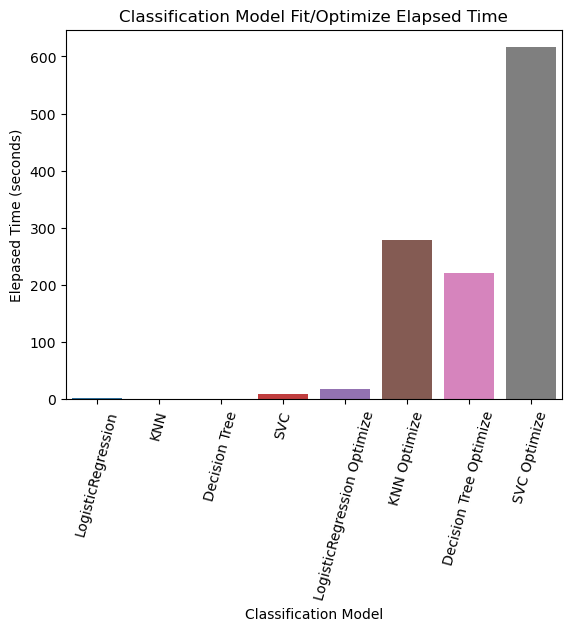

In [78]:
# Plot Elapsed Time
sns.barplot(dfTrack, 
            x='model',
            y='Train Time')
plt.ylabel('Elepased Time (seconds)')
plt.xlabel('Classification Model')
plt.xticks(rotation = 75)
plt.title('Classification Model Fit/Optimize Elapsed Time')
plt.show()

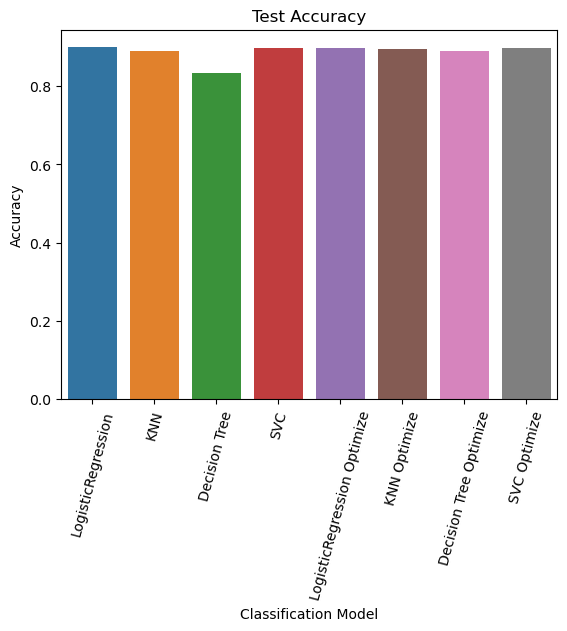

In [79]:
# Plot Test Accuracy
sns.barplot(dfTrack, 
            x='model',
            y='Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Classification Model')
plt.xticks(rotation = 75)
plt.title('Test Accuracy')
plt.show()

#### Results - Optimization
Not a significant difference in accuracy between the basic models vs the optimize models.  Base on our goal to select the best prediction model with interpretable results; the best model would be Decision Tree Optimize Model.  This model had the second best optimize time, optimize accuracy is at 89% like the other models, and the results are interpretable by analyzing the decision tree.

A performance, fit/optimize time, comparison Logistic Regression Optimize had the fastest time but also the fewest hyperparameters to optimize.  Decision Tree was the second fastest optimize time but with the most hyperparameters to optimize.  SVM had the slowest performance but using the full train dataset instead of the reduced train dataset.  Given the all models produce accuracy test scores of 89% from a perfomance point of view decision tree is also the best model.

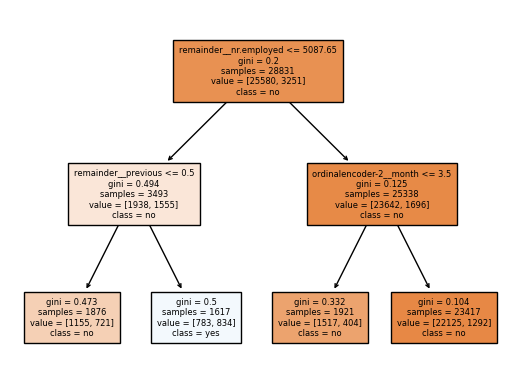

In [80]:
tree = plot_tree(
    dt_best.named_steps['dt'], 
    feature_names=dt_best.named_steps['transformer'].get_feature_names_out(), 
    class_names=['no', 'yes'],
    filled = True,
    fontsize=6)

According to the decision tree the more relevant features are nr.employed, previous and month.  

##### Questions

None of the Bank Client data features were important for the prediction.  The decision tree results suggest that the campaign acceptance has more to do with call center percitance and customer follow up. I find this intriguing and merits further analysis just to define feature importance as it relates to campaign acceptance (y). An option would be to perform a Permutation Importance analysis.